In [248]:
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.ndimage import zoom, rotate
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import os
import numpy as np
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Activation, Input, Dense, Reshape, Flatten, Dropout, GaussianNoise
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.engine.saving import load_model
import matplotlib.pyplot as plt
from skimage import measure

In [249]:
chair = sio.loadmat('model/IKEA_chair_STEFAN_a216f9b7e1b632b42808fa16c469cb1f_obj0_object.mat')
table = sio.loadmat('model/IKEA_table_SALMI_3ebb9bfa2afb2f8c9db5a91069a42c6a_obj0_object.mat')

In [250]:
def plot(arr):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.voxels((arr>0.7),antialiased=False, linewidth=0.0)
    plt.show()


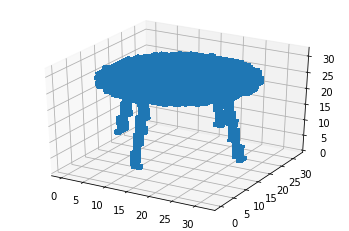

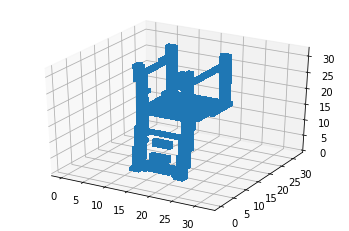

In [251]:
table_x = (rotate(zoom(table["voxel"],(0.5,0.5,0.5)),180,(0,1)))
chair_x = (rotate(zoom(chair["voxel"],(0.5,0.5,0.5)),180,(0,1)))
plot(table_x)
plot(chair_x)

In [265]:
class GAN(object):
    def __init__(self, width=128, height=128, depth=128):
        self.width = width
        self.height = height
        self.depth = depth
        self.size = width * height * depth
        self.shape = (self.width, self.height, self.depth)
        self.latent = 320 
        self.OPTIMIZER = Adam(0.0001,0.5)
        
        self.G = self.generator()
        self.D = self.discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy']) # categorical

        self.stacked_G_D = self.stacked_G_D()
        self.stacked_G_D.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER) 

    def generator(self):
        model = Sequential()
        model.add(GaussianNoise(0.2, input_shape=(self.latent,)))
        model.add(Dense(self.size,kernel_initializer='random_uniform',)) 
        model.add(Dropout(0.2))
        model.add(Dense(512))
        model.add(BatchNormalization(momentum=0.8))
        model.add(GaussianNoise(0.2))
        model.add(Dense(256))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.2))
        model.add(Dense(self.size))
        model.add(Activation("tanh"))
        model.add(Reshape(self.shape))
       
        model.summary()
        return model

    def discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.shape))
        model.add(GaussianNoise(0.2))
        model.add(Dropout(0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1))
        model.add(Activation("sigmoid"))

        return model
    

    def stacked_G_D(self):
        self.D.trainable = False

        model = Sequential()
        model.add(self.G)
        model.add(self.D)

        return model


    def train(self, X_train, epochs=10000, batch=2, save_interval=20):
        valid = np.ones((batch, 1))
        fake = np.zeros((batch, 1))
        for cnt in range(epochs):
            noise = np.random.normal(0, 1, (batch, self.latent))
            legit_images = X_train.reshape(batch, self.width, self.height, self.depth)
            
            syntetic_images = self.G.predict(noise)
            
      
            d_loss = 0.5 * np.add(self.D.train_on_batch(legit_images, valid),
                                  self.D.train_on_batch(syntetic_images, fake)) 
            g_loss = self.stacked_G_D.train_on_batch(noise, valid)

            if cnt % save_interval == 0 and cnt > 0:
                result = self.D.predict(syntetic_images)[0] 
                print ("%d [D loss: %f] [G loss: %f] classified as %f" % (cnt, d_loss[0], g_loss, result[0] ))
                plot(syntetic_images[0])

    def save(self):
        self.D.save('./trained/D')
        self.G.save('./trained/G')
        self.stacked_G_D.save('./trained/GAN')
    def load(grid_size):
        gan = GAN(width=grid_size, height=grid_size, depth=grid_size)
        gan.D = load_model('./trained/D')
        gan.G = load_model('./trained/G')
        gan.stacked_G_D = load_model('./trained/GAN')
        return gan



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_24 (GaussianN (None, 320)               0         
_________________________________________________________________
dense_336 (Dense)            (None, 32768)             10518528  
_________________________________________________________________
dropout_39 (Dropout)         (None, 32768)             0         
_________________________________________________________________
dense_337 (Dense)            (None, 512)               16777728  
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
gaussian_noise_25 (GaussianN (None, 512)               0         
_________________________________________________________________
dense_338 (Dense)            (None, 256)               131328    
__________

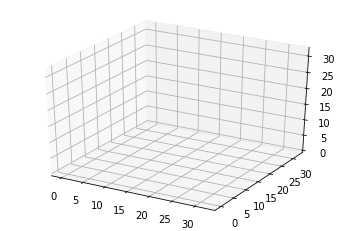

40 [D loss: 0.190770] [G loss: 1.071200] classified as 0.024675


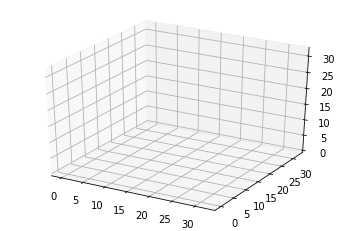

60 [D loss: 0.550065] [G loss: 1.998457] classified as 0.521761


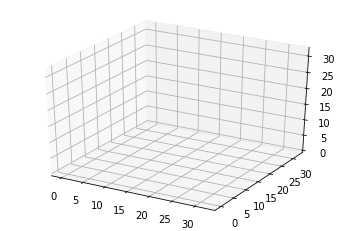

80 [D loss: 0.285888] [G loss: 2.175333] classified as 0.098872


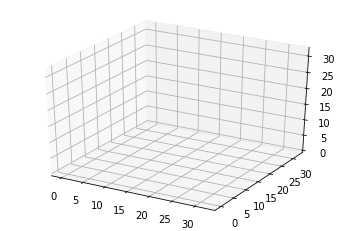

100 [D loss: 0.070675] [G loss: 2.336428] classified as 0.129905


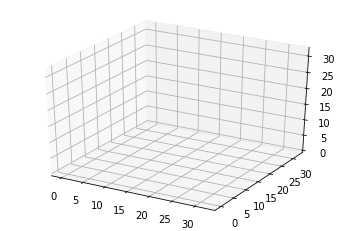

120 [D loss: 0.052376] [G loss: 5.211857] classified as 0.000562


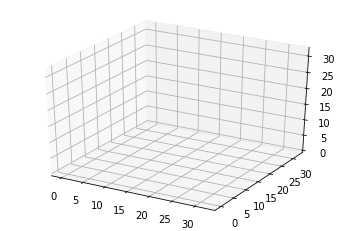

140 [D loss: 0.120647] [G loss: 3.562108] classified as 0.113311


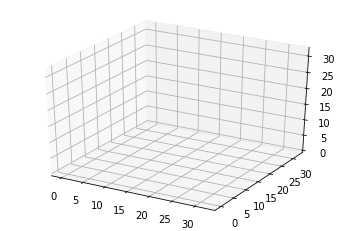

160 [D loss: 0.063223] [G loss: 2.747105] classified as 0.155002


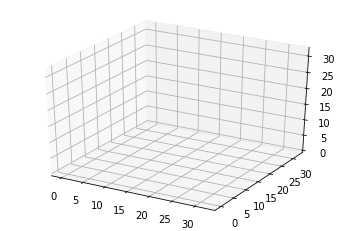

180 [D loss: 0.026312] [G loss: 4.560773] classified as 0.020162


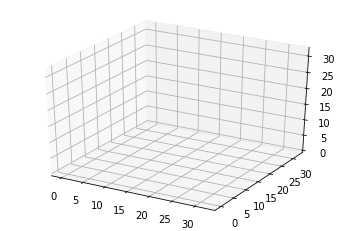

200 [D loss: 0.178977] [G loss: 2.455978] classified as 0.038017


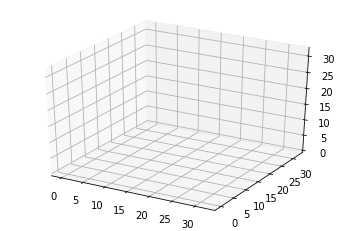

220 [D loss: 0.021224] [G loss: 3.215464] classified as 0.000629


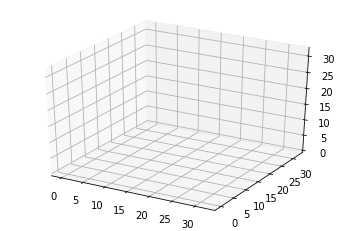

240 [D loss: 0.124579] [G loss: 6.833045] classified as 0.006734


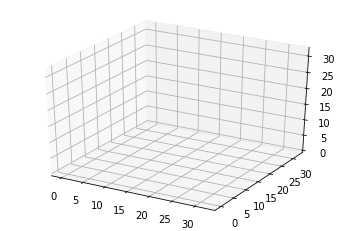

260 [D loss: 0.094569] [G loss: 6.851306] classified as 0.017749


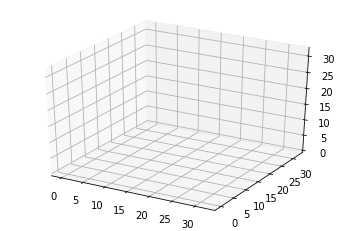

280 [D loss: 0.080511] [G loss: 4.453942] classified as 0.038328


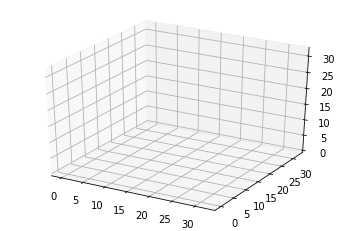

300 [D loss: 0.018319] [G loss: 8.458639] classified as 0.004887


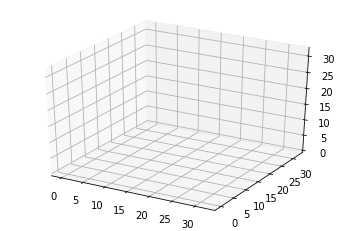

320 [D loss: 0.267932] [G loss: 9.443843] classified as 0.000298


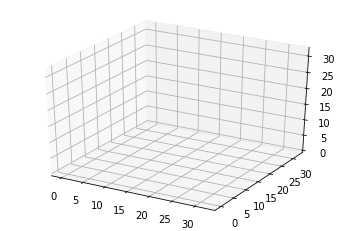

340 [D loss: 0.019080] [G loss: 6.602827] classified as 0.000001


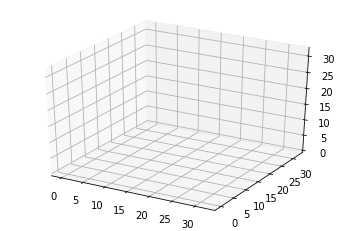

360 [D loss: 0.193932] [G loss: 9.469753] classified as 0.000000


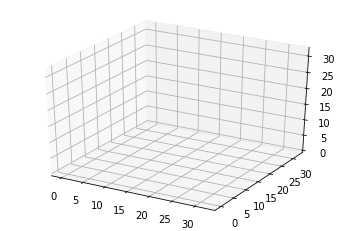

380 [D loss: 0.036638] [G loss: 5.377982] classified as 0.000001


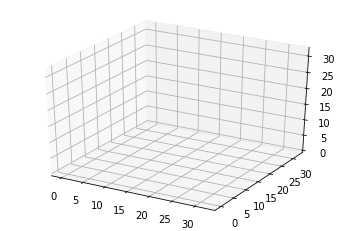

400 [D loss: 0.050261] [G loss: 5.018652] classified as 0.023095


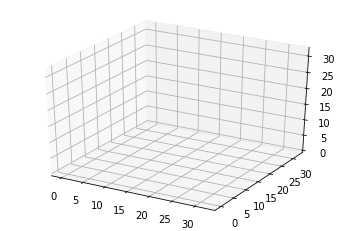

420 [D loss: 0.014591] [G loss: 6.022342] classified as 0.056491


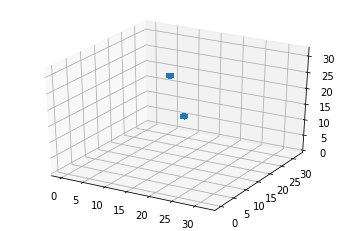

440 [D loss: 0.037725] [G loss: 4.683424] classified as 0.001771


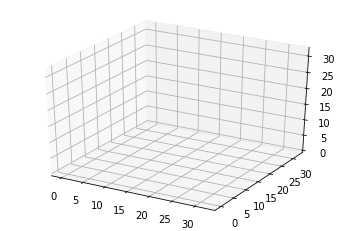

460 [D loss: 0.110088] [G loss: 5.430599] classified as 0.028285


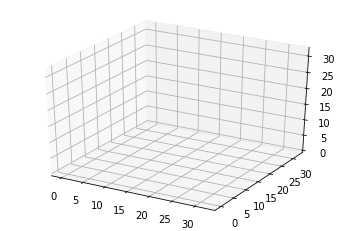

480 [D loss: 0.017567] [G loss: 2.976294] classified as 0.006796


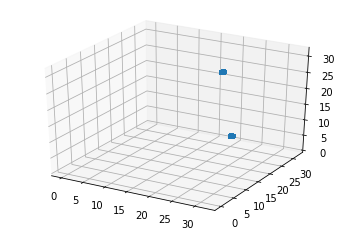

500 [D loss: 0.035493] [G loss: 5.525921] classified as 0.000713


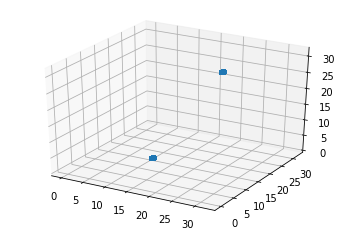

520 [D loss: 0.005070] [G loss: 3.939091] classified as 0.000008


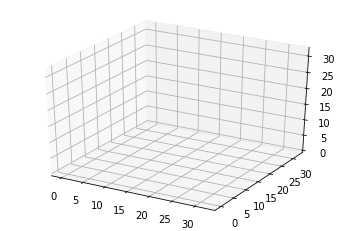

540 [D loss: 0.062294] [G loss: 5.765605] classified as 0.049356


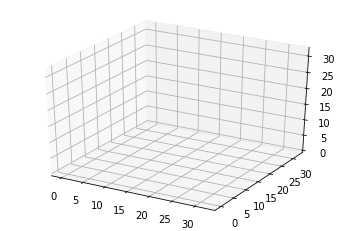

560 [D loss: 0.011479] [G loss: 7.046189] classified as 0.042845


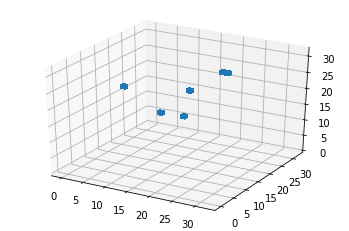

580 [D loss: 0.049987] [G loss: 5.757558] classified as 0.049293


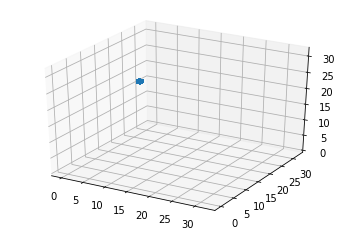

600 [D loss: 0.016169] [G loss: 2.804288] classified as 0.007431


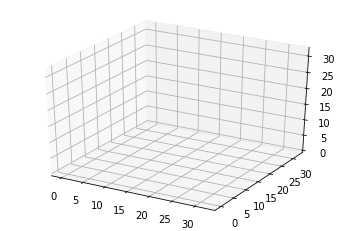

620 [D loss: 0.040262] [G loss: 3.580973] classified as 0.005068


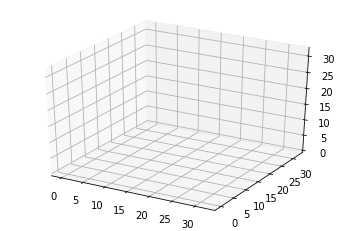

640 [D loss: 0.111839] [G loss: 5.458760] classified as 0.045440


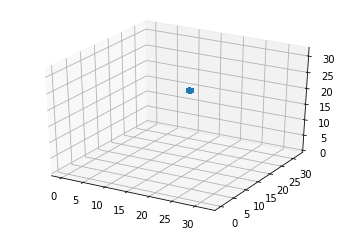

660 [D loss: 0.011066] [G loss: 5.130824] classified as 0.005911


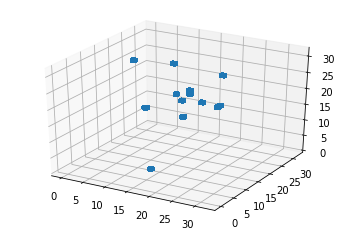

680 [D loss: 0.024024] [G loss: 2.884300] classified as 0.005710


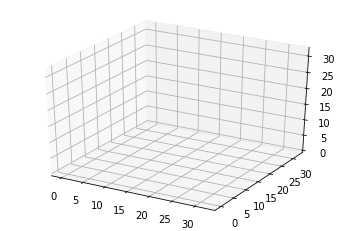

700 [D loss: 0.183087] [G loss: 8.180664] classified as 0.000481


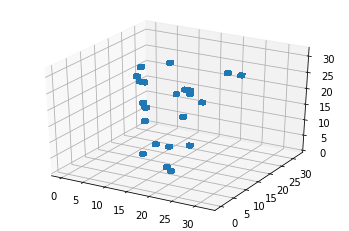

720 [D loss: 0.386977] [G loss: 2.847216] classified as 0.000111


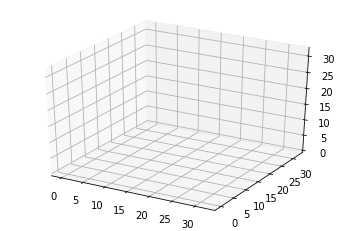

740 [D loss: 0.041120] [G loss: 3.536689] classified as 0.003794


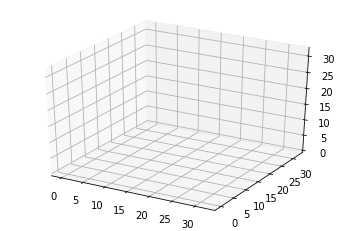

760 [D loss: 0.030464] [G loss: 3.564055] classified as 0.125688


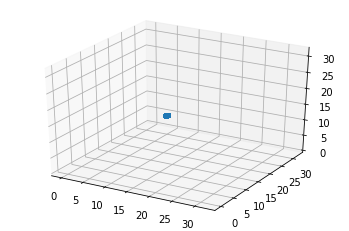

780 [D loss: 0.013505] [G loss: 15.985695] classified as 0.000316


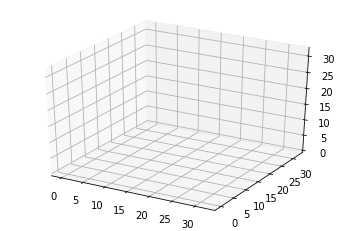

800 [D loss: 0.003054] [G loss: 10.154637] classified as 0.000000


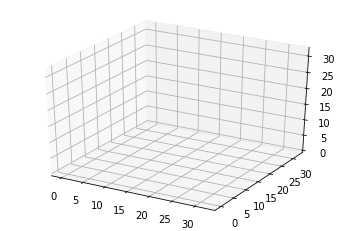

820 [D loss: 0.027482] [G loss: 5.069169] classified as 0.002467


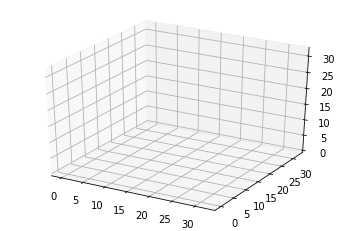

840 [D loss: 0.019715] [G loss: 12.532586] classified as 0.003152


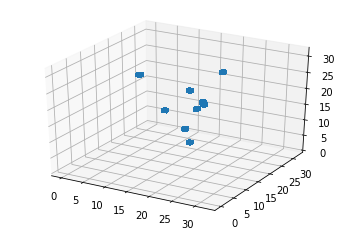

860 [D loss: 0.024812] [G loss: 7.704012] classified as 0.013601


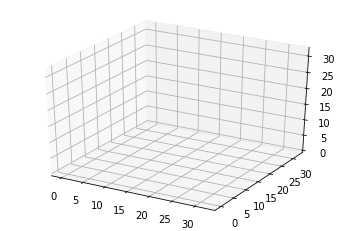

880 [D loss: 0.046092] [G loss: 8.460558] classified as 0.000105


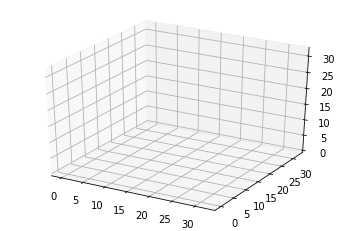

900 [D loss: 0.007778] [G loss: 3.964175] classified as 0.023822


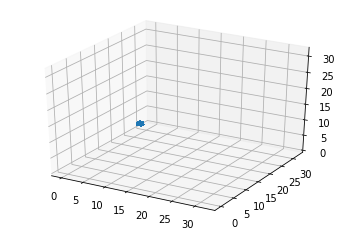

920 [D loss: 0.282565] [G loss: 8.146175] classified as 0.001515


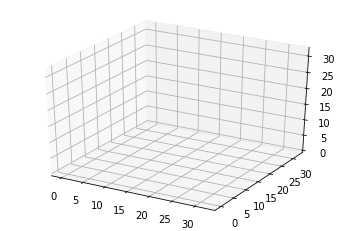

940 [D loss: 0.008477] [G loss: 5.284037] classified as 0.008839


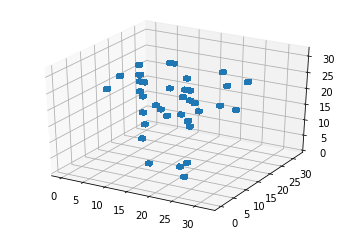

960 [D loss: 0.254073] [G loss: 3.969763] classified as 0.000020


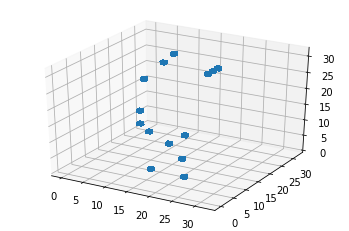

980 [D loss: 0.013969] [G loss: 3.094828] classified as 0.001315


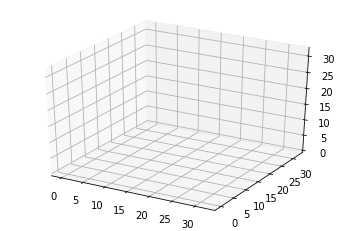

1000 [D loss: 0.055612] [G loss: 5.362706] classified as 0.000824


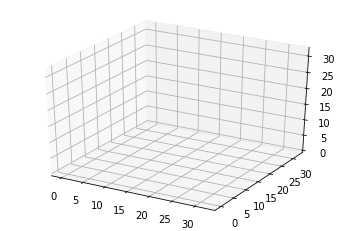

1020 [D loss: 0.019448] [G loss: 5.481773] classified as 0.009892


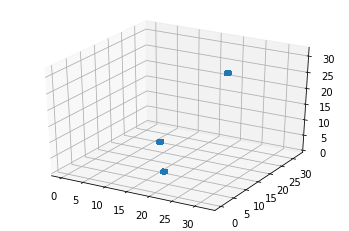

1040 [D loss: 0.012165] [G loss: 9.156832] classified as 0.003758


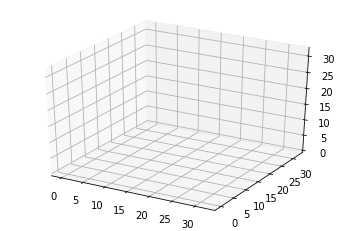

1060 [D loss: 0.006560] [G loss: 5.287888] classified as 0.000017


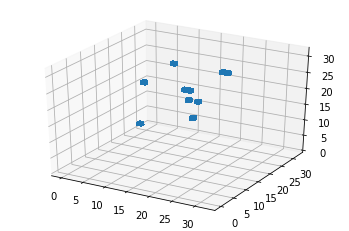

1080 [D loss: 0.071422] [G loss: 4.171237] classified as 0.000056


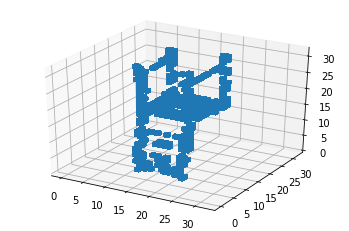

1100 [D loss: 0.028830] [G loss: 5.091606] classified as 0.048477


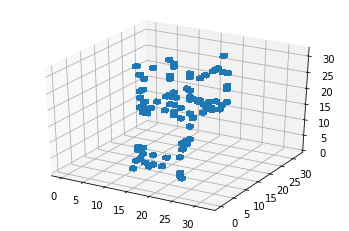

1120 [D loss: 0.006480] [G loss: 4.125514] classified as 0.002864


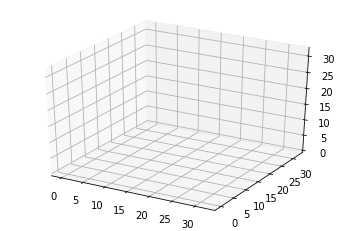

1140 [D loss: 0.038498] [G loss: 6.765915] classified as 0.002061


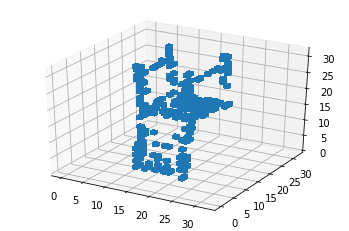

1160 [D loss: 0.007866] [G loss: 6.468794] classified as 0.001160


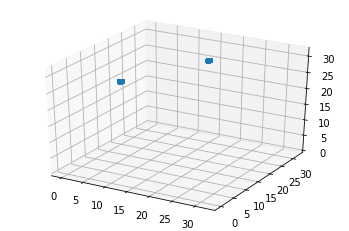

1180 [D loss: 0.103976] [G loss: 4.745670] classified as 0.006263


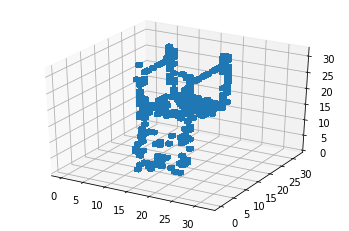

1200 [D loss: 0.201839] [G loss: 11.762227] classified as 0.000002


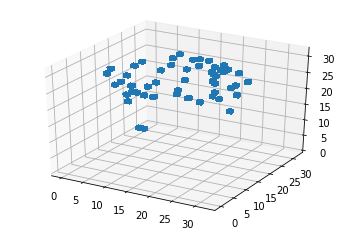

1220 [D loss: 0.043623] [G loss: 5.619859] classified as 0.017138


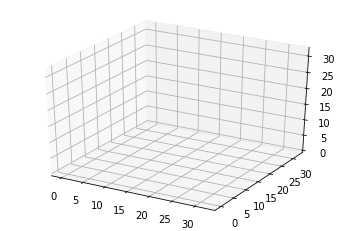

1240 [D loss: 0.041202] [G loss: 6.864635] classified as 0.011650


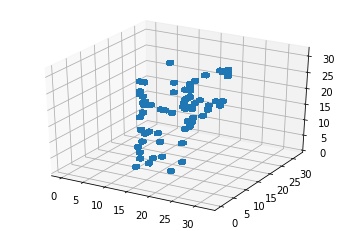

1260 [D loss: 0.021582] [G loss: 8.966440] classified as 0.005960


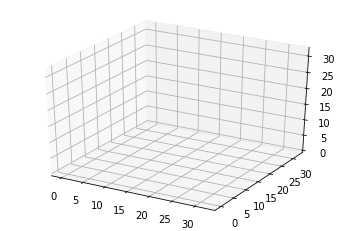

1280 [D loss: 0.023311] [G loss: 5.497565] classified as 0.028321


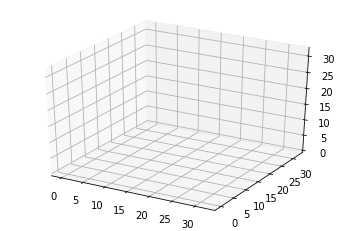

1300 [D loss: 0.089098] [G loss: 6.282723] classified as 0.016527


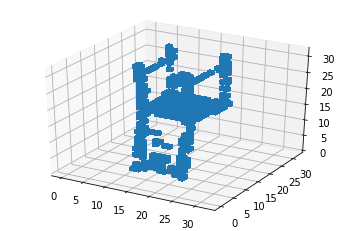

1320 [D loss: 0.006857] [G loss: 7.197145] classified as 0.000768


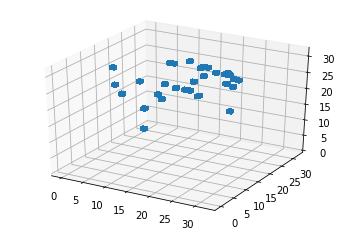

1340 [D loss: 0.009034] [G loss: 3.815087] classified as 0.000082


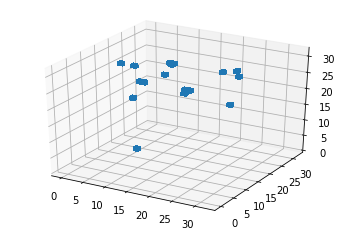

1360 [D loss: 0.008880] [G loss: 14.012737] classified as 0.000000


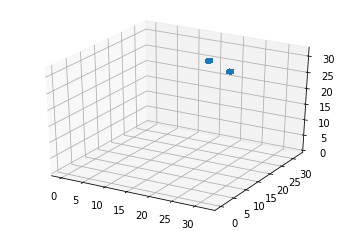

1380 [D loss: 0.313470] [G loss: 4.379662] classified as 0.000024


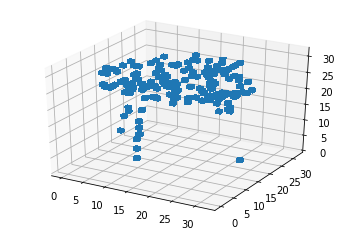

1400 [D loss: 0.006094] [G loss: 6.252898] classified as 0.003670


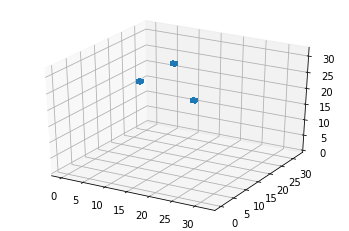

1420 [D loss: 0.500448] [G loss: 10.048216] classified as 0.000030


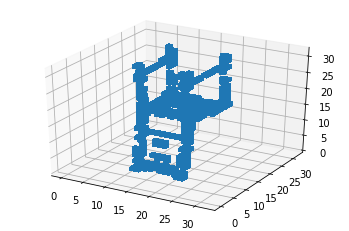

1440 [D loss: 0.056048] [G loss: 2.643842] classified as 0.005407


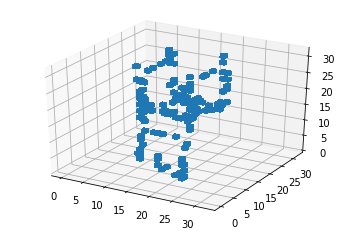

1460 [D loss: 0.065272] [G loss: 6.693319] classified as 0.005443


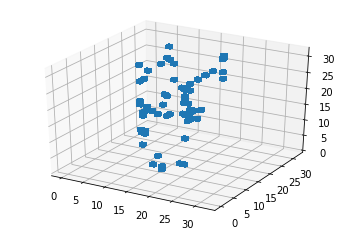

1480 [D loss: 0.012921] [G loss: 9.582651] classified as 0.000001


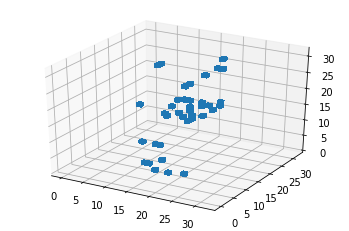

1500 [D loss: 0.081533] [G loss: 3.663181] classified as 0.002140


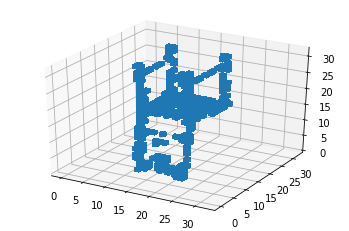

1520 [D loss: 0.035133] [G loss: 16.118095] classified as 0.012874


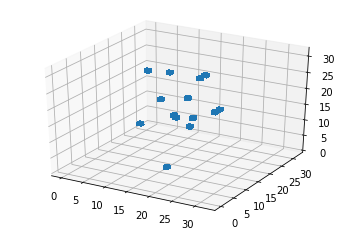

1540 [D loss: 0.006284] [G loss: 6.066092] classified as 0.024575


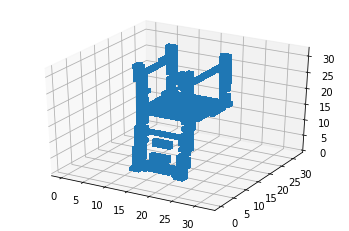

1560 [D loss: 0.393902] [G loss: 9.636042] classified as 0.000363


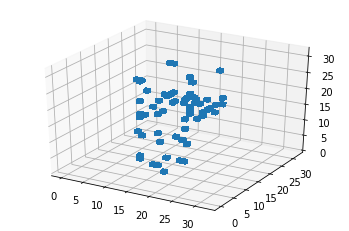

1580 [D loss: 0.010870] [G loss: 8.011548] classified as 0.047009


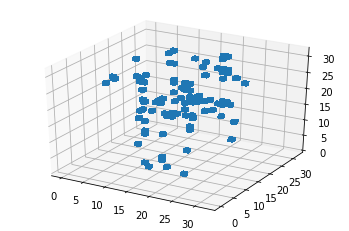

1600 [D loss: 0.746317] [G loss: 7.600216] classified as 0.003117


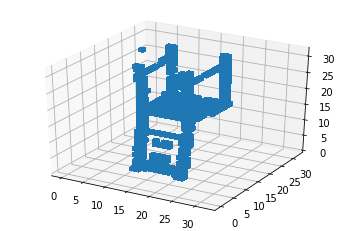

1620 [D loss: 0.038868] [G loss: 3.798315] classified as 0.001263


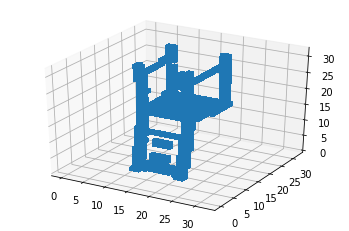

1640 [D loss: 0.564775] [G loss: 12.963913] classified as 0.000057


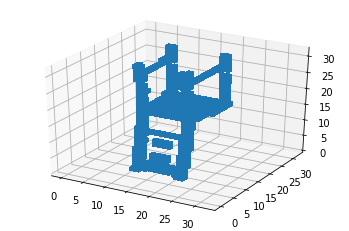

1660 [D loss: 0.046562] [G loss: 3.974466] classified as 0.006598


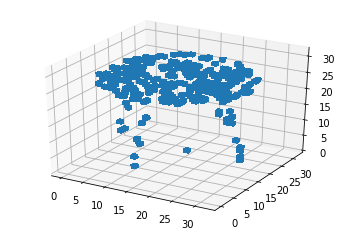

1680 [D loss: 0.008186] [G loss: 11.141848] classified as 0.000000


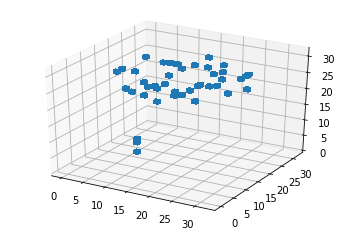

1700 [D loss: 0.060336] [G loss: 3.907022] classified as 0.002081


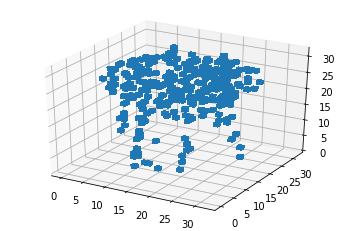

1720 [D loss: 0.029254] [G loss: 7.786735] classified as 0.000000


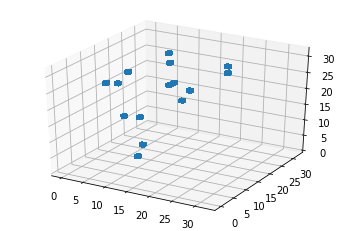

1740 [D loss: 0.051888] [G loss: 8.245754] classified as 0.016269


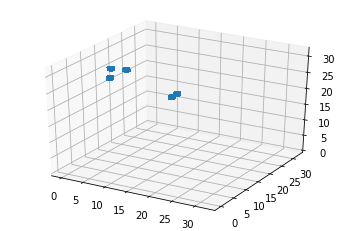

1760 [D loss: 0.035994] [G loss: 5.550322] classified as 0.003751


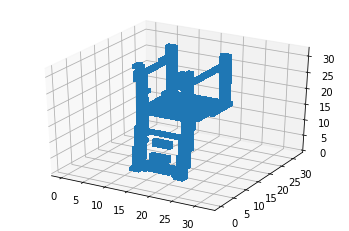

1780 [D loss: 0.121097] [G loss: 11.960732] classified as 0.000095


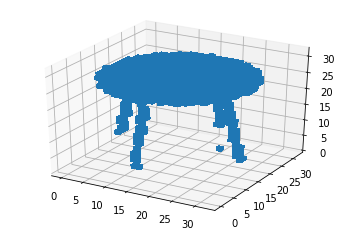

1800 [D loss: 0.005017] [G loss: 12.009796] classified as 0.000203


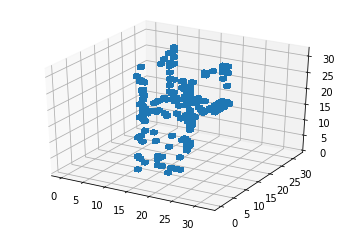

1820 [D loss: 0.055731] [G loss: 4.195283] classified as 0.013439


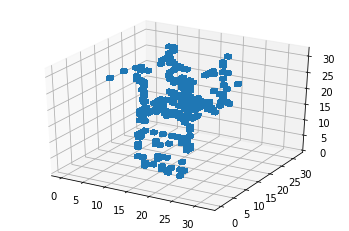

1840 [D loss: 0.155336] [G loss: 10.076475] classified as 0.000486


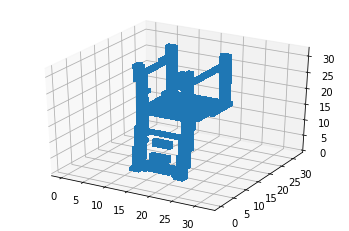

1860 [D loss: 0.050107] [G loss: 3.068667] classified as 0.000827


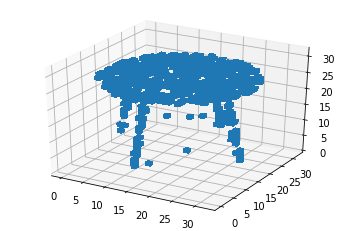

1880 [D loss: 0.013386] [G loss: 15.785774] classified as 0.000001


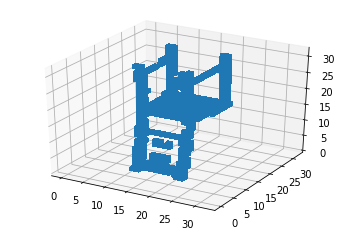

1900 [D loss: 0.004690] [G loss: 9.821142] classified as 0.009220


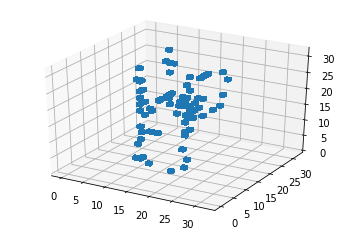

1920 [D loss: 0.005295] [G loss: 8.393360] classified as 0.001707


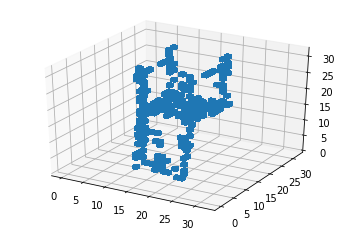

1940 [D loss: 0.022550] [G loss: 6.757032] classified as 0.000000


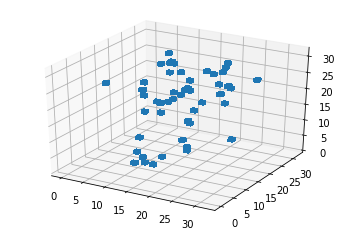

1960 [D loss: 0.289649] [G loss: 5.896683] classified as 0.000251


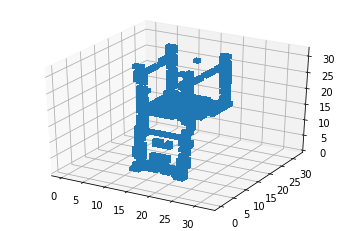

1980 [D loss: 0.038776] [G loss: 7.707553] classified as 0.001212


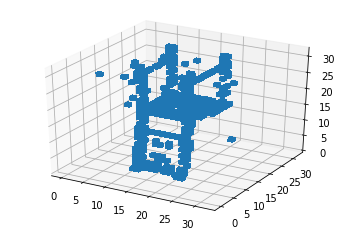

2000 [D loss: 0.081143] [G loss: 7.214677] classified as 0.000019


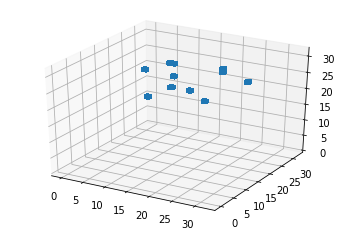

2020 [D loss: 0.010560] [G loss: 6.851203] classified as 0.000002


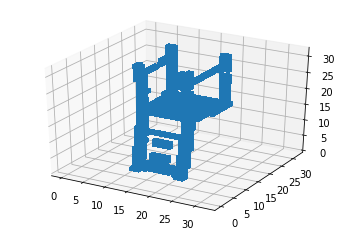

2040 [D loss: 0.059344] [G loss: 5.740263] classified as 0.000000


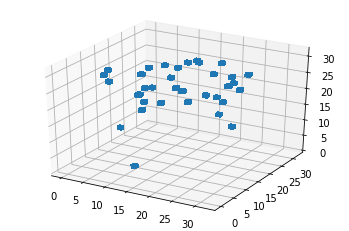

2060 [D loss: 0.017506] [G loss: 3.426240] classified as 0.000000


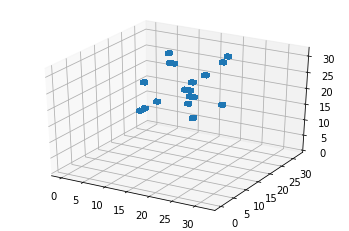

2080 [D loss: 0.028472] [G loss: 4.018758] classified as 0.043376


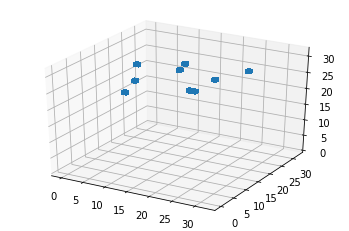

2100 [D loss: 0.638194] [G loss: 11.203565] classified as 0.000000


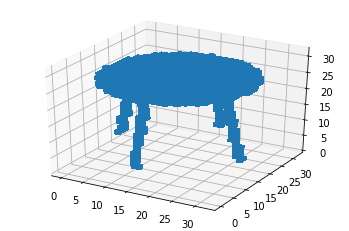

2120 [D loss: 0.004317] [G loss: 8.651783] classified as 0.000133


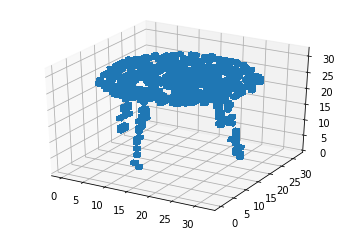

2140 [D loss: 0.089310] [G loss: 8.459838] classified as 0.011899


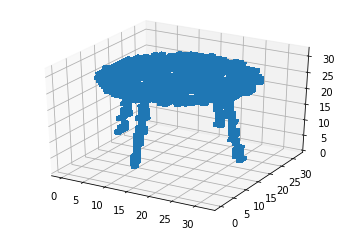

2160 [D loss: 0.013719] [G loss: 6.181982] classified as 0.000003


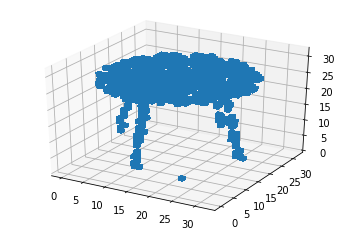

2180 [D loss: 0.052208] [G loss: 2.525967] classified as 0.006627


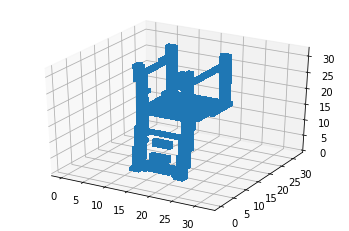

2200 [D loss: 0.006527] [G loss: 15.099030] classified as 0.000007


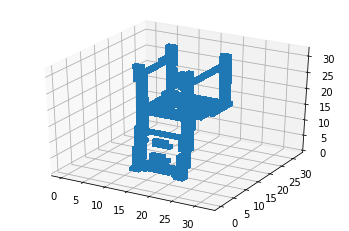

2220 [D loss: 0.123510] [G loss: 6.637990] classified as 0.000486


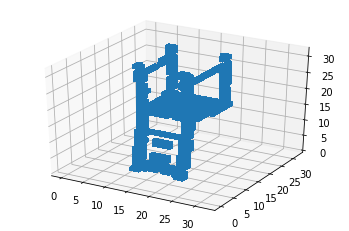

2240 [D loss: 0.049650] [G loss: 4.078731] classified as 0.000048


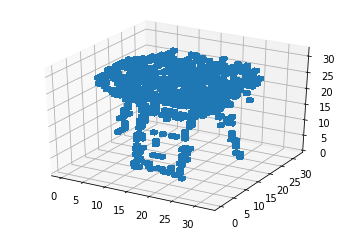

2260 [D loss: 0.033626] [G loss: 10.735826] classified as 0.005094


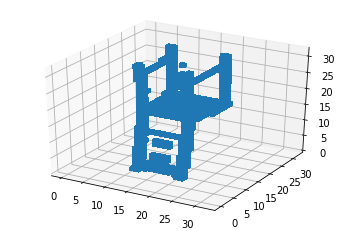

2280 [D loss: 0.026550] [G loss: 3.774632] classified as 0.032485


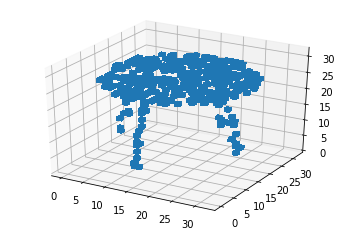

2300 [D loss: 0.006632] [G loss: 14.393980] classified as 0.000000


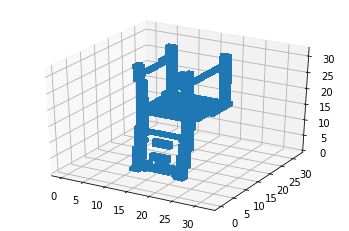

2320 [D loss: 0.007813] [G loss: 9.500693] classified as 0.000000


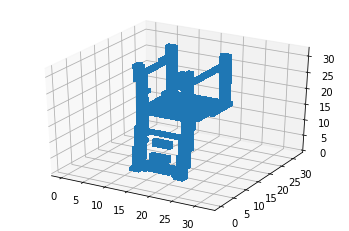

2340 [D loss: 0.005446] [G loss: 4.615285] classified as 0.010199


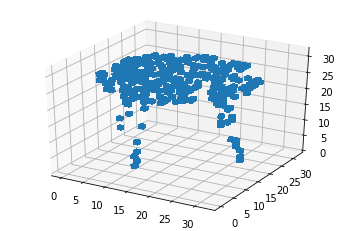

2360 [D loss: 0.017855] [G loss: 15.619127] classified as 0.000000


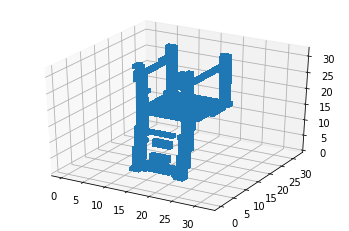

2380 [D loss: 0.043220] [G loss: 16.118095] classified as 0.000000


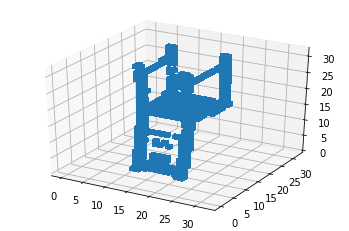

2400 [D loss: 0.005615] [G loss: 12.498489] classified as 0.000002


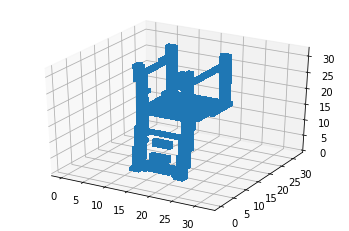

2420 [D loss: 0.009868] [G loss: 1.853745] classified as 0.001556


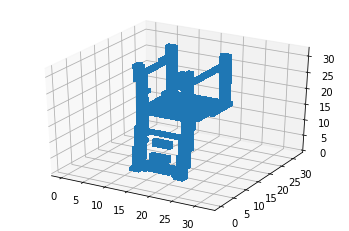

2440 [D loss: 0.032577] [G loss: 7.216281] classified as 0.000221


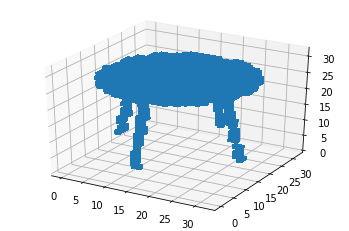

2460 [D loss: 0.003126] [G loss: 7.887877] classified as 0.000002


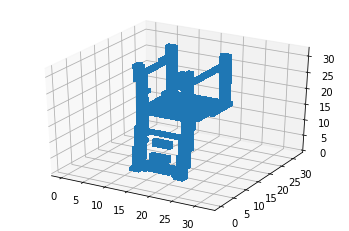

2480 [D loss: 0.004822] [G loss: 9.619768] classified as 0.000000


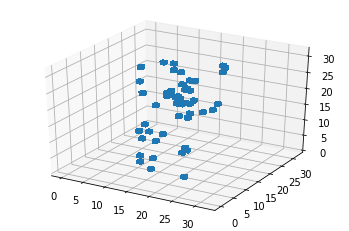

2500 [D loss: 0.012652] [G loss: 9.962626] classified as 0.000000


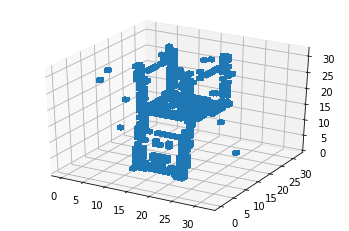

2520 [D loss: 0.005048] [G loss: 16.118095] classified as 0.000000


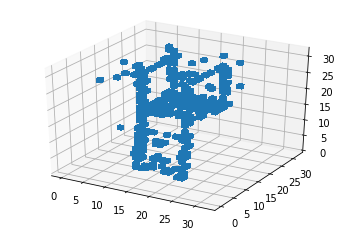

2540 [D loss: 0.515119] [G loss: 12.758032] classified as 0.000000


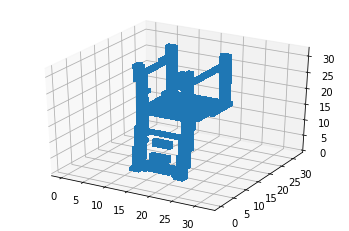

2560 [D loss: 0.001816] [G loss: 16.118095] classified as 0.000000


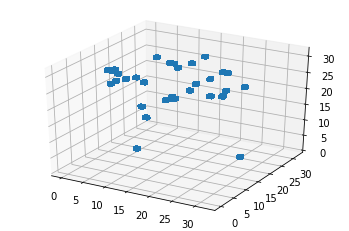

2580 [D loss: 0.009432] [G loss: 11.895797] classified as 0.000229


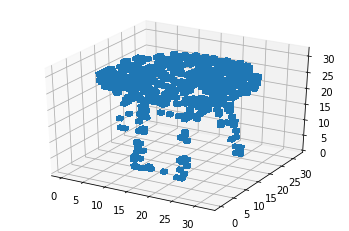

2600 [D loss: 0.008023] [G loss: 13.157987] classified as 0.000311


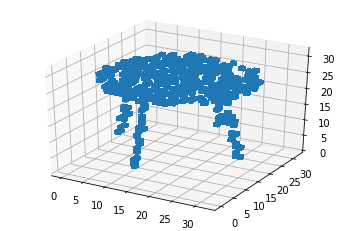

2620 [D loss: 0.012790] [G loss: 9.656021] classified as 0.005074


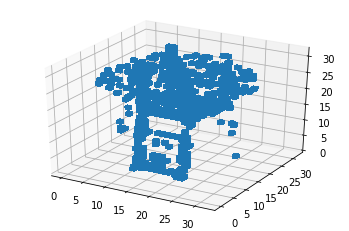

2640 [D loss: 0.059191] [G loss: 16.118095] classified as 0.078276


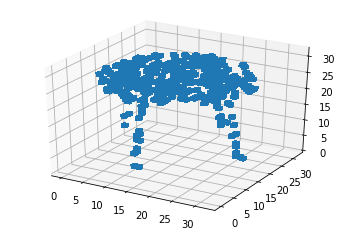

2660 [D loss: 0.009944] [G loss: 15.858597] classified as 0.000000


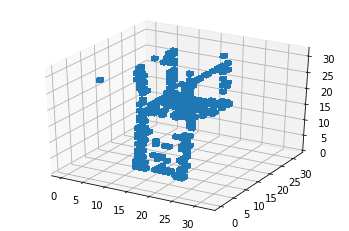

2680 [D loss: 0.005029] [G loss: 11.893999] classified as 0.000000


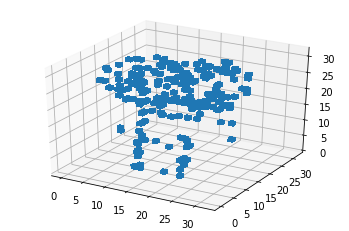

2700 [D loss: 0.206354] [G loss: 11.917858] classified as 0.000000


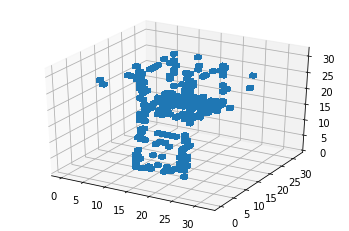

2720 [D loss: 0.002702] [G loss: 16.118095] classified as 0.000001


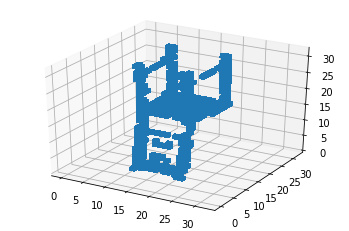

2740 [D loss: 0.003284] [G loss: 15.054731] classified as 0.173776


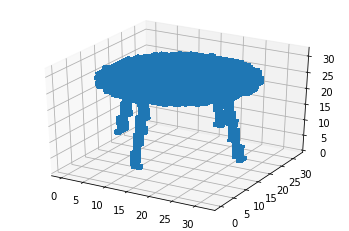

2760 [D loss: 0.006864] [G loss: 10.542709] classified as 0.000000


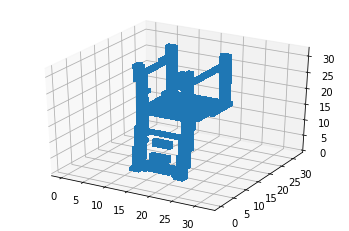

2780 [D loss: 0.037358] [G loss: 10.427974] classified as 0.000000


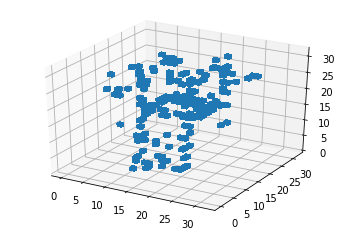

2800 [D loss: 0.028384] [G loss: 5.088930] classified as 0.011828


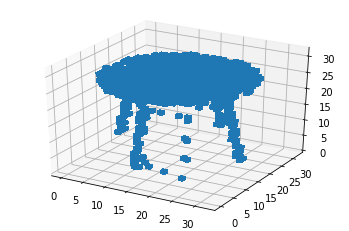

2820 [D loss: 0.004621] [G loss: 16.118095] classified as 0.000000


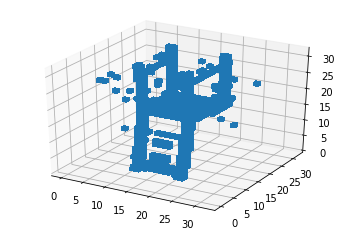

2840 [D loss: 0.006097] [G loss: 7.217488] classified as 0.000000


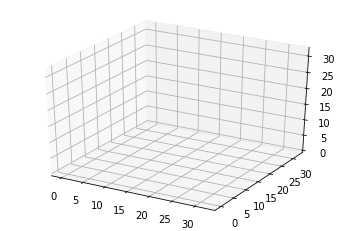

2860 [D loss: 0.001985] [G loss: 16.118095] classified as 0.000215


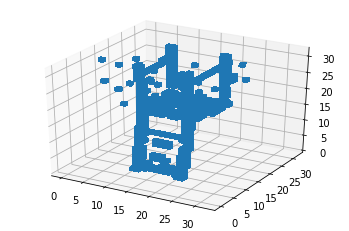

2880 [D loss: 0.086775] [G loss: 12.831553] classified as 0.000000


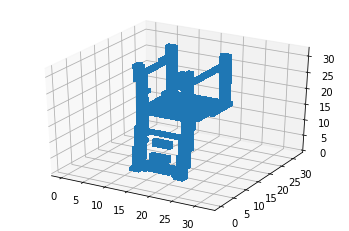

2900 [D loss: 0.002181] [G loss: 16.118095] classified as 0.000333


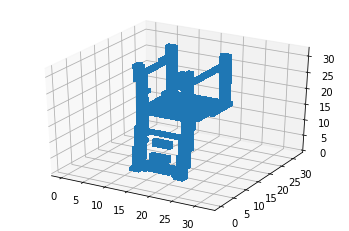

2920 [D loss: 0.002198] [G loss: 16.118095] classified as 0.000016


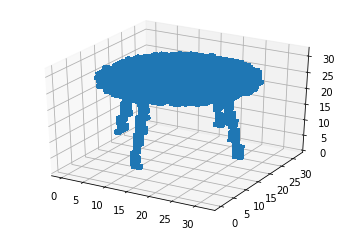

2940 [D loss: 0.017483] [G loss: 9.772509] classified as 0.003949


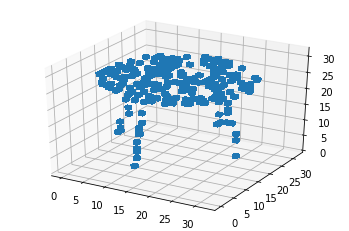

2960 [D loss: 0.010748] [G loss: 6.757423] classified as 0.000000


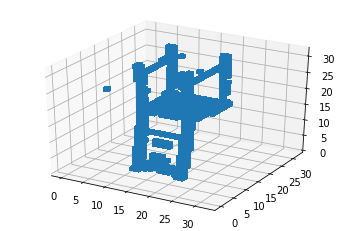

2980 [D loss: 0.000615] [G loss: 16.118095] classified as 0.000121


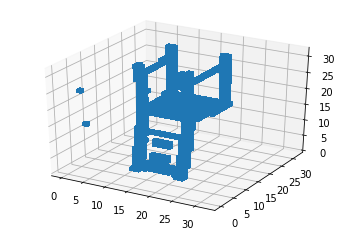

3000 [D loss: 0.016956] [G loss: 8.870905] classified as 0.009602


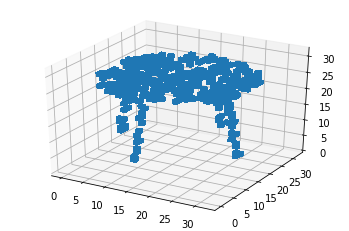

3020 [D loss: 0.036562] [G loss: 16.118095] classified as 0.000000


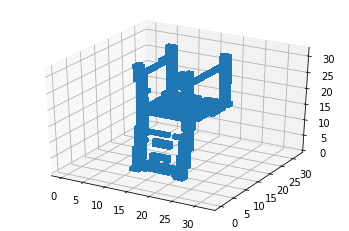

3040 [D loss: 0.205297] [G loss: 5.879095] classified as 0.000318


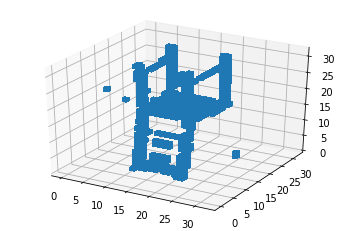

3060 [D loss: 0.002085] [G loss: 6.630164] classified as 0.000093


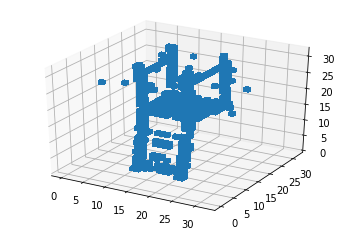

3080 [D loss: 1.562603] [G loss: 16.118095] classified as 0.000000


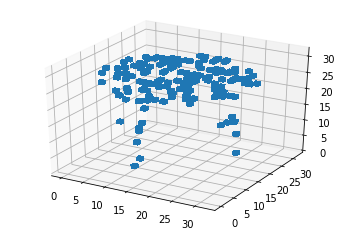

3100 [D loss: 0.368595] [G loss: 12.548724] classified as 0.000199


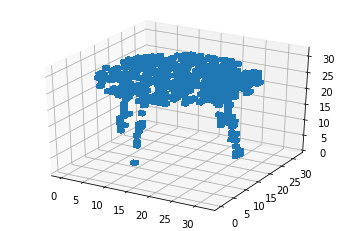

3120 [D loss: 0.075086] [G loss: 6.231587] classified as 0.001471


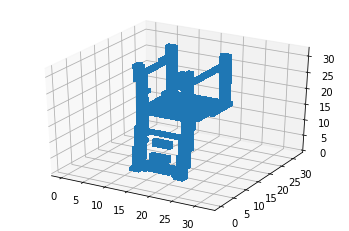

3140 [D loss: 0.001564] [G loss: 10.329312] classified as 0.000000


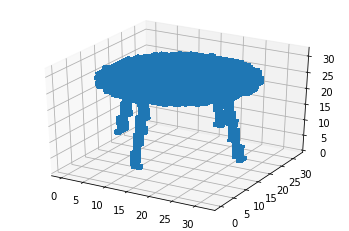

3160 [D loss: 0.008892] [G loss: 13.796111] classified as 0.000000


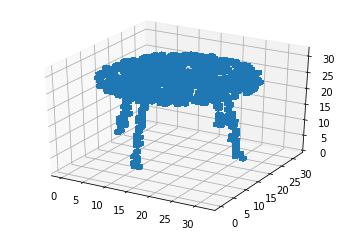

3180 [D loss: 0.328797] [G loss: 9.249435] classified as 0.000000


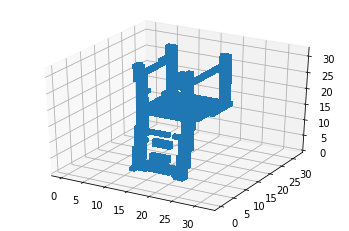

3200 [D loss: 0.005524] [G loss: 16.118095] classified as 0.000000


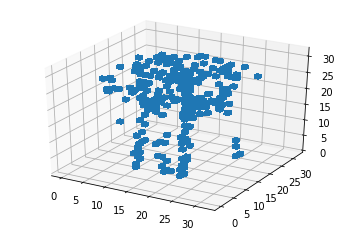

3220 [D loss: 0.002501] [G loss: 13.855764] classified as 0.000000


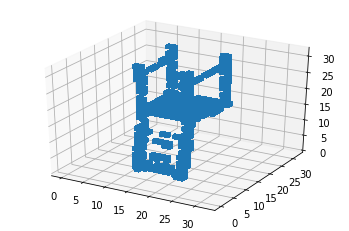

3240 [D loss: 0.012465] [G loss: 16.118095] classified as 0.002110


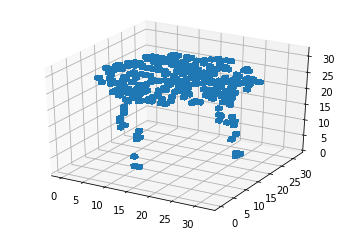

3260 [D loss: 0.033378] [G loss: 16.118095] classified as 0.000000


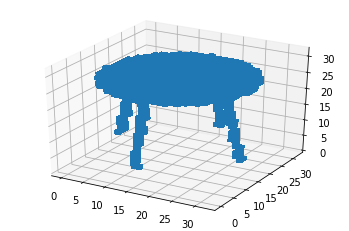

3280 [D loss: 0.001991] [G loss: 16.118095] classified as 0.005451


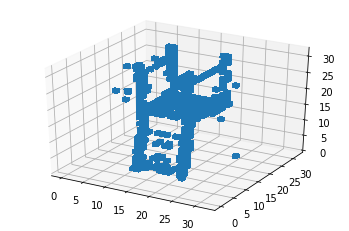

3300 [D loss: 0.001708] [G loss: 8.582696] classified as 0.000021


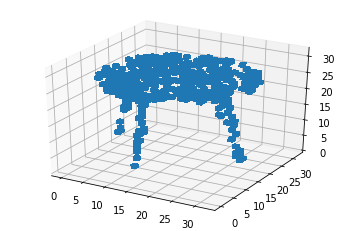

3320 [D loss: 0.007242] [G loss: 16.118095] classified as 0.000000


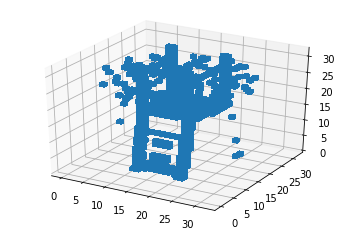

3340 [D loss: 0.022283] [G loss: 16.118095] classified as 0.004848


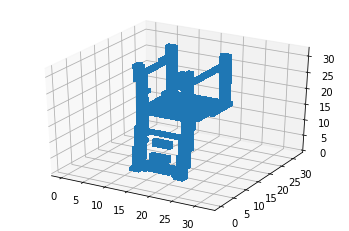

3360 [D loss: 0.007153] [G loss: 2.005530] classified as 0.002009


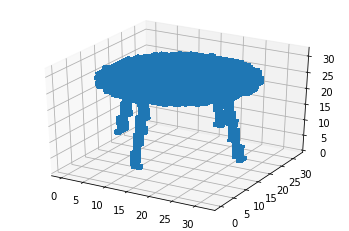

3380 [D loss: 0.050191] [G loss: 16.118095] classified as 0.001546


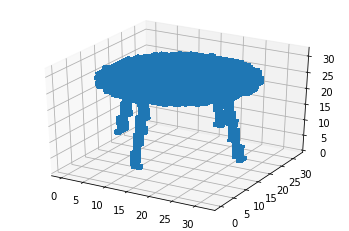

3400 [D loss: 0.256180] [G loss: 11.850105] classified as 0.000000


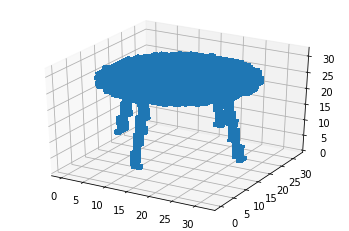

3420 [D loss: 0.012486] [G loss: 16.118095] classified as 0.000000


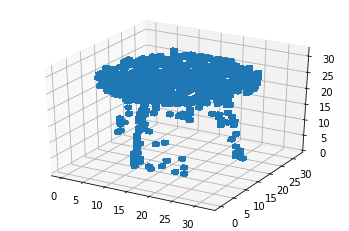

3440 [D loss: 0.001481] [G loss: 16.118095] classified as 0.000000


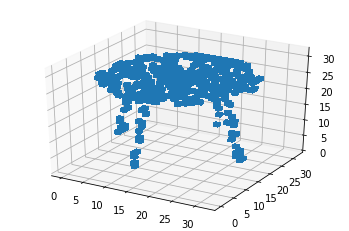

3460 [D loss: 0.005797] [G loss: 7.127861] classified as 0.033905


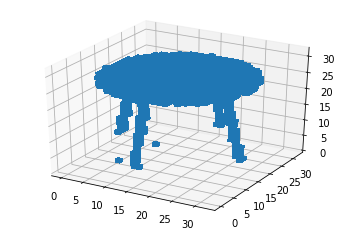

3480 [D loss: 0.002564] [G loss: 16.118095] classified as 0.006585


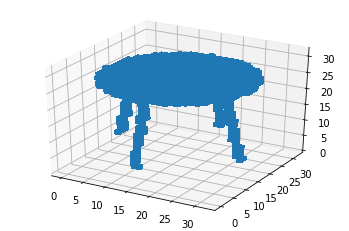

3500 [D loss: 0.000842] [G loss: 16.118095] classified as 0.000000


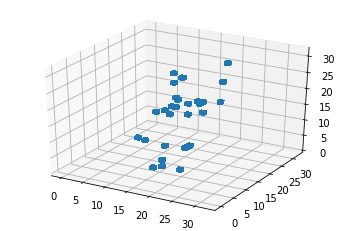

3520 [D loss: 0.001602] [G loss: 16.118095] classified as 0.002566


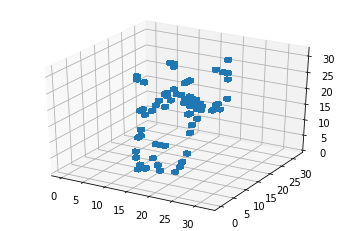

3540 [D loss: 0.003973] [G loss: 16.118095] classified as 0.000000


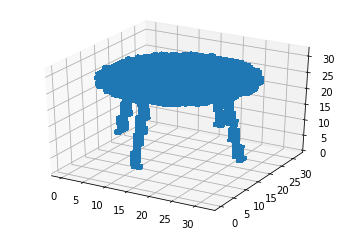

3560 [D loss: 0.000757] [G loss: 10.328959] classified as 0.000264


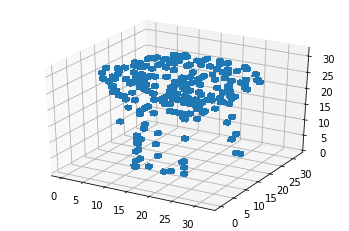

3580 [D loss: 0.001716] [G loss: 3.140110] classified as 0.000000


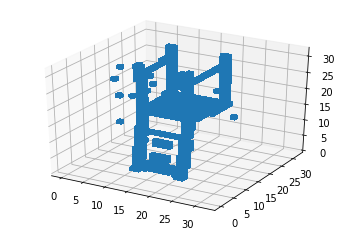

3600 [D loss: 0.004918] [G loss: 14.527060] classified as 0.000062


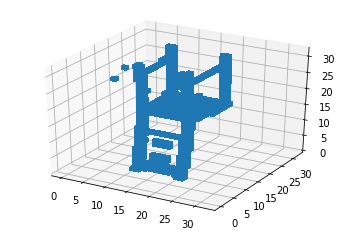

3620 [D loss: 0.009579] [G loss: 9.123830] classified as 0.000000


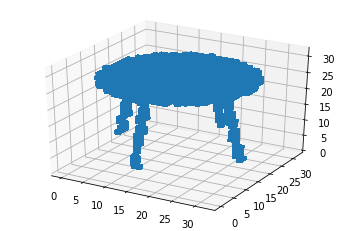

3640 [D loss: 0.005377] [G loss: 16.118095] classified as 0.000051


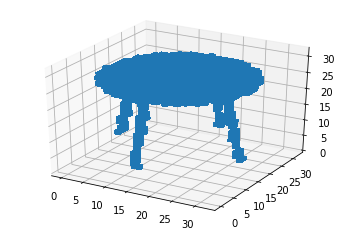

3660 [D loss: 0.007121] [G loss: 16.118095] classified as 0.001135


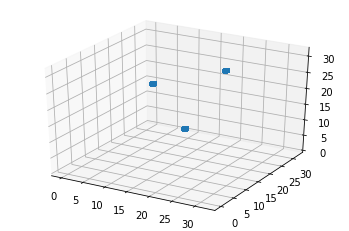

3680 [D loss: 0.003842] [G loss: 16.118095] classified as 0.000000


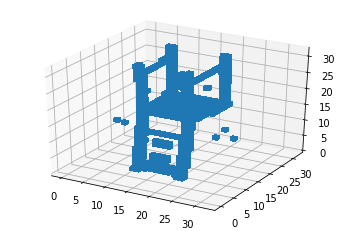

3700 [D loss: 0.002790] [G loss: 10.049259] classified as 0.000000


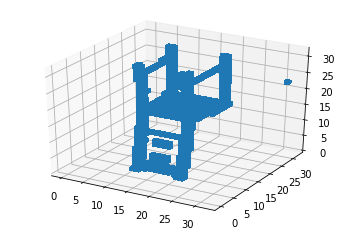

3720 [D loss: 0.001472] [G loss: 16.118095] classified as 0.000000


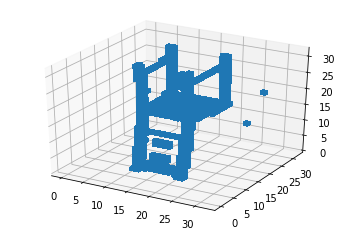

3740 [D loss: 0.043746] [G loss: 6.527925] classified as 0.000000


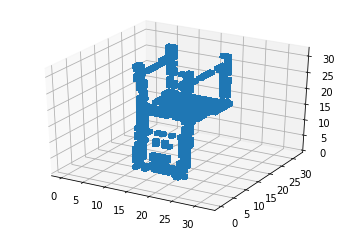

3760 [D loss: 0.004507] [G loss: 16.118095] classified as 0.000000


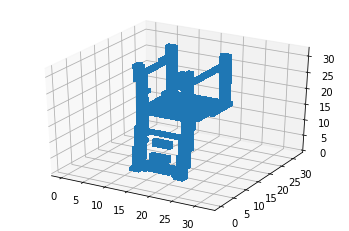

3780 [D loss: 0.000232] [G loss: 13.980356] classified as 0.000006


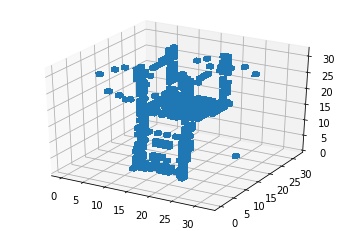

3800 [D loss: 0.016567] [G loss: 16.118095] classified as 0.000000


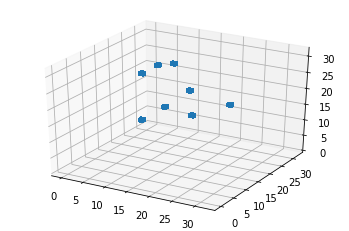

3820 [D loss: 0.047989] [G loss: 7.474854] classified as 0.000000


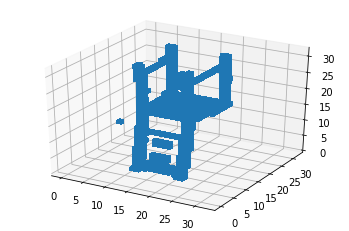

3840 [D loss: 0.002388] [G loss: 14.916823] classified as 0.000000


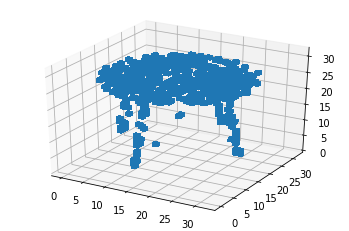

3860 [D loss: 0.001331] [G loss: 6.773900] classified as 0.000000


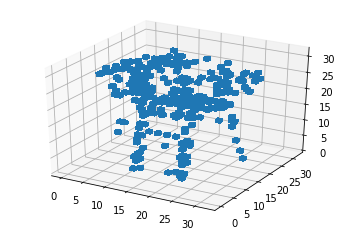

3880 [D loss: 0.012145] [G loss: 16.118095] classified as 0.012343


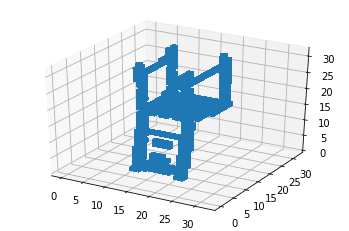

3900 [D loss: 0.002569] [G loss: 15.659352] classified as 0.000367


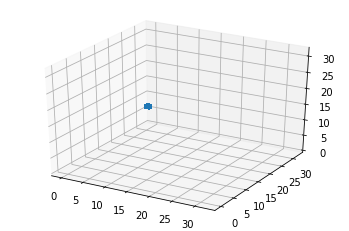

3920 [D loss: 0.000646] [G loss: 3.435253] classified as 0.000000


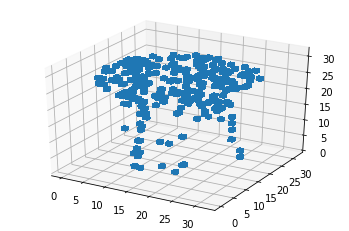

3940 [D loss: 0.001385] [G loss: 13.093202] classified as 0.000000


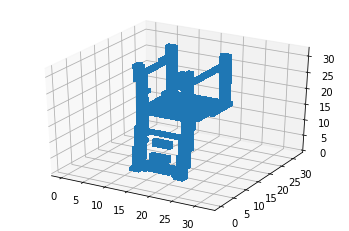

3960 [D loss: 0.003215] [G loss: 3.568658] classified as 0.000000


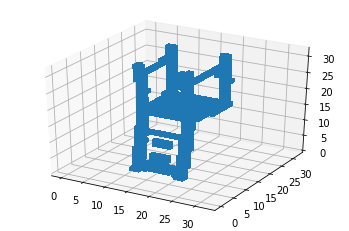

3980 [D loss: 0.007164] [G loss: 16.118095] classified as 0.000000


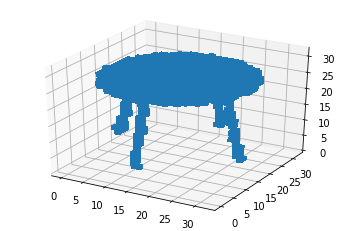

4000 [D loss: 0.029808] [G loss: 16.118095] classified as 0.000012


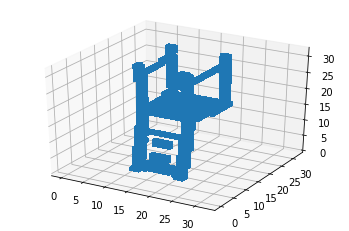

4020 [D loss: 0.003283] [G loss: 16.118095] classified as 0.000000


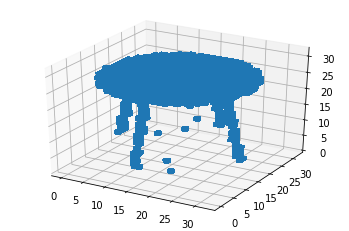

4040 [D loss: 0.004407] [G loss: 14.939396] classified as 0.002119


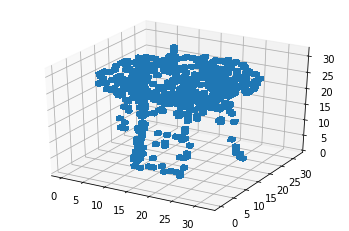

4060 [D loss: 0.000180] [G loss: 3.919285] classified as 0.000000


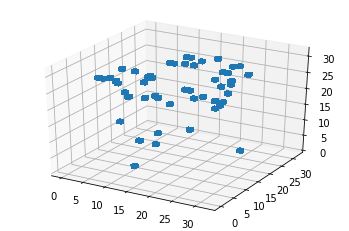

4080 [D loss: 0.001520] [G loss: 8.977724] classified as 0.000000


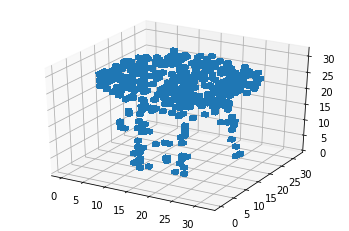

4100 [D loss: 0.000172] [G loss: 13.792678] classified as 0.000000


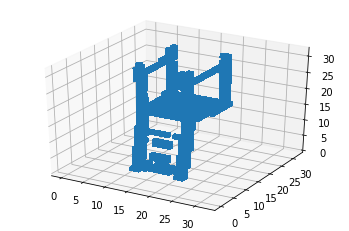

4120 [D loss: 0.000625] [G loss: 16.118095] classified as 0.000000


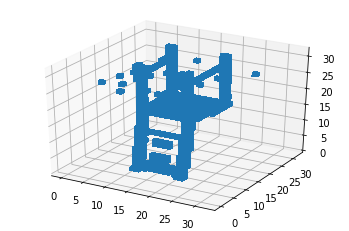

4140 [D loss: 0.015140] [G loss: 10.664823] classified as 0.000000


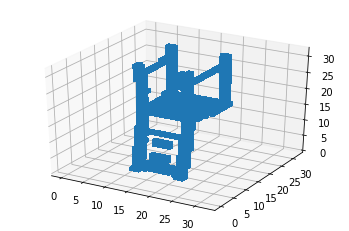

4160 [D loss: 0.004682] [G loss: 16.118095] classified as 0.000000


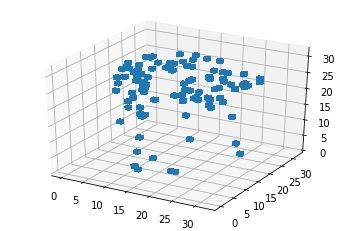

4180 [D loss: 0.000714] [G loss: 8.513391] classified as 0.000000


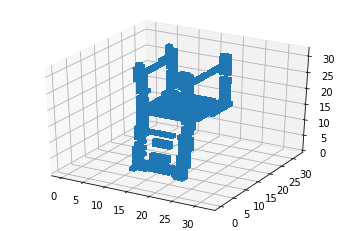

4200 [D loss: 0.005608] [G loss: 16.118095] classified as 0.000000


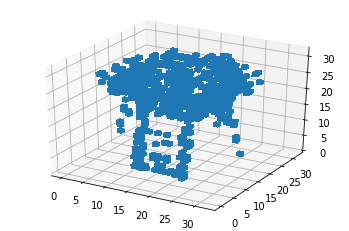

4220 [D loss: 0.000199] [G loss: 15.324762] classified as 0.000000


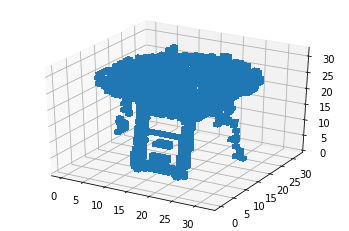

4240 [D loss: 0.007061] [G loss: 16.118095] classified as 0.000021


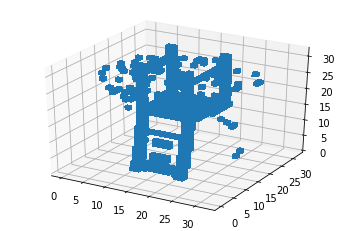

4260 [D loss: 0.001353] [G loss: 15.098175] classified as 0.000000


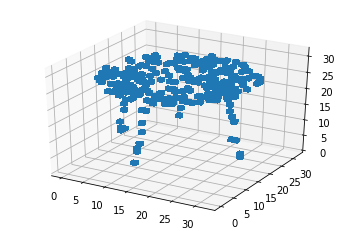

4280 [D loss: 0.054480] [G loss: 16.118095] classified as 0.000000


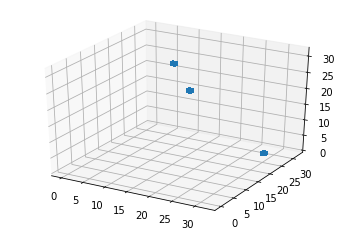

4300 [D loss: 0.001962] [G loss: 16.118095] classified as 0.000000


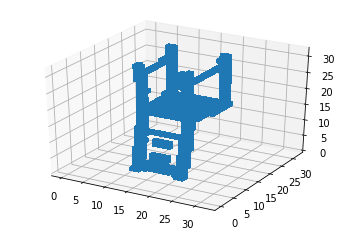

4320 [D loss: 0.321053] [G loss: 11.405571] classified as 0.000000


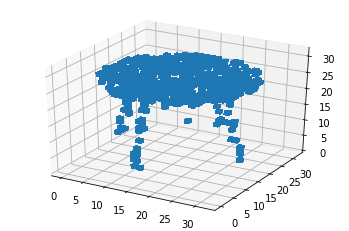

4340 [D loss: 0.001675] [G loss: 16.118095] classified as 0.000000


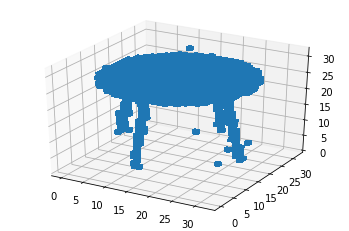

4360 [D loss: 0.003617] [G loss: 16.118095] classified as 0.000000


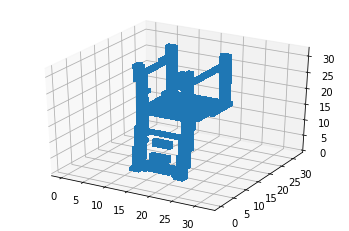

4380 [D loss: 0.008097] [G loss: 12.784814] classified as 0.000000


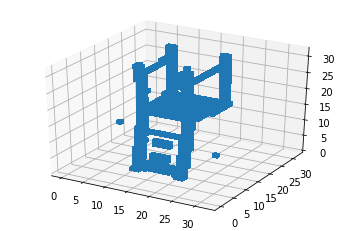

4400 [D loss: 0.001799] [G loss: 16.118095] classified as 0.000034


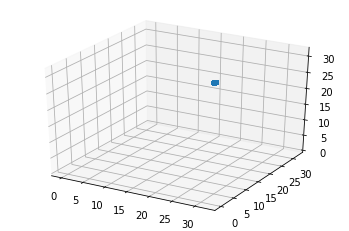

4420 [D loss: 0.001070] [G loss: 16.118095] classified as 0.000000


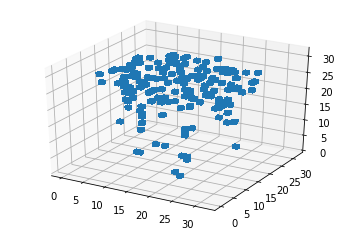

4440 [D loss: 0.031870] [G loss: 16.118095] classified as 0.000000


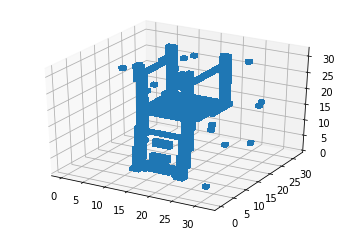

4460 [D loss: 0.001837] [G loss: 15.890688] classified as 0.000000


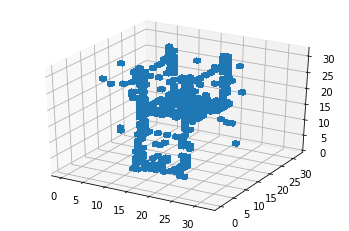

4480 [D loss: 0.010238] [G loss: 16.118095] classified as 0.000000


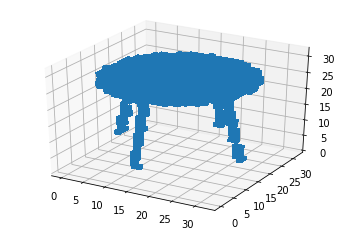

4500 [D loss: 0.066326] [G loss: 11.373280] classified as 0.000150


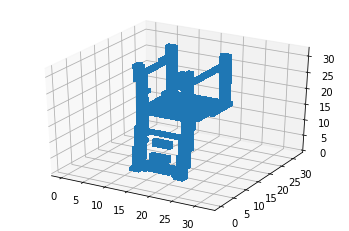

4520 [D loss: 0.809198] [G loss: 16.118095] classified as 0.000000


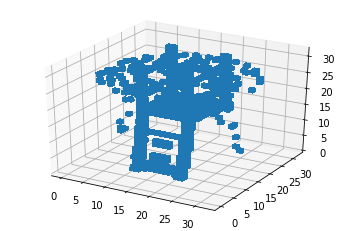

4540 [D loss: 0.003915] [G loss: 16.118095] classified as 0.000000


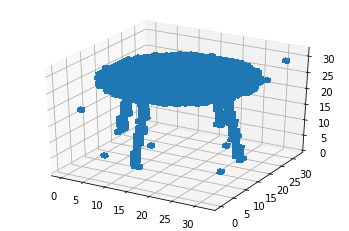

4560 [D loss: 0.000786] [G loss: 16.118095] classified as 0.000000


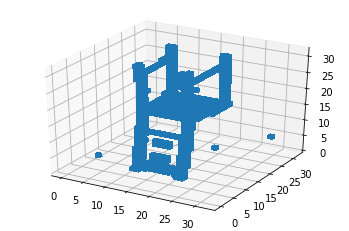

4580 [D loss: 0.001843] [G loss: 16.118095] classified as 0.000000


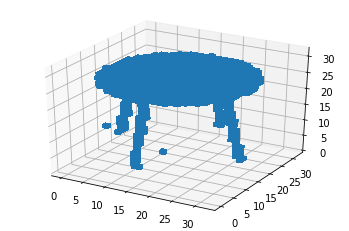

4600 [D loss: 0.000895] [G loss: 10.544914] classified as 0.000000


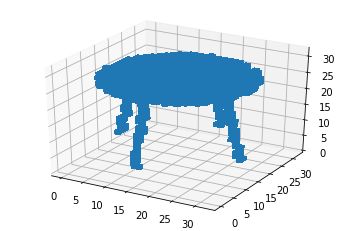

4620 [D loss: 0.000268] [G loss: 16.118095] classified as 0.000000


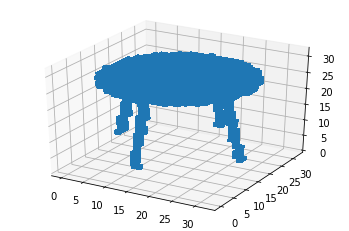

4640 [D loss: 0.000942] [G loss: 16.118095] classified as 0.000000


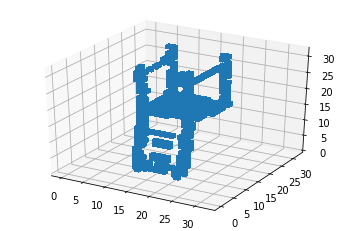

4660 [D loss: 0.004459] [G loss: 16.118095] classified as 0.000000


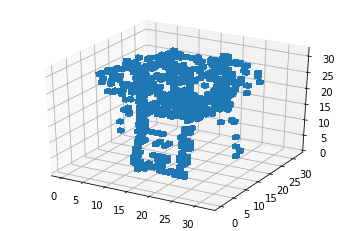

4680 [D loss: 0.018090] [G loss: 13.368427] classified as 0.000723


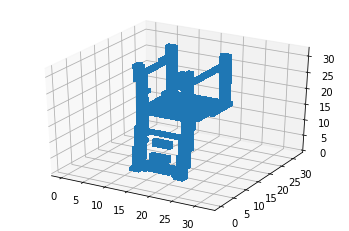

KeyboardInterrupt: 

In [256]:
grid_size = 32
train_x = np.asarray([chair_x,table_x])
where_are_NaNs = np.isnan(train_x)
train_x[where_are_NaNs] = 0

gan = GAN(width=grid_size, height=grid_size, depth=grid_size)
gan.train(train_x)
gan.save()

In [266]:
gan = GAN.load(32)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_33 (GaussianN (None, 320)               0         
_________________________________________________________________
dense_357 (Dense)            (None, 32768)             10518528  
_________________________________________________________________
dropout_51 (Dropout)         (None, 32768)             0         
_________________________________________________________________
dense_358 (Dense)            (None, 512)               16777728  
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
gaussian_noise_34 (GaussianN (None, 512)               0         
_________________________________________________________________
dense_359 (Dense)            (None, 256)               131328    
__________

/usr/local/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


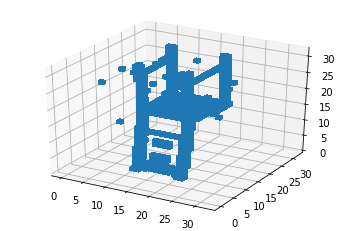

In [274]:
noise = np.random.normal(0, 1, (2, gan.latent))
plot(gan.G.predict(noise)[0])


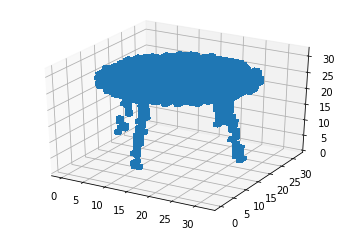

In [275]:
noiseb = np.random.normal(0, 1, (2, gan.latent))
plot(gan.G.predict(noiseb)[0])

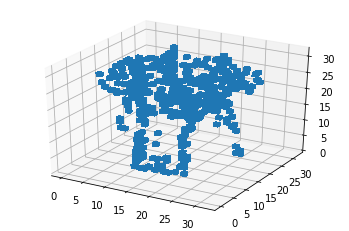

In [291]:
plot(gan.G.predict((1*noiseb+1*noise)/2)[0])